In [1]:
%matplotlib widget
from typing import Tuple, Dict
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm

import seaborn as sns

from opinion_model import (
    average_k,
    generate_opinions, describe_graph,
    Opinion, balance_opinions,
    SUGGESTABILITY_KEY, OPINION_KEY
)

BASE_SUGGESTABILITY = 1

# Test

In [2]:
graph = nx.DiGraph()

op = [
    (1, 2),
    (1, 3),
    (2, 3),
    (2, 4),
    (3, 1),
    (3, 2),
    (4, 3),
    (5, 3),
    (5, 6),
    (4, 6),
    (6, 5),
    (6, 8),
    (7, 4),
    (7, 6),
    (8, 9),
    (9, 7),
    (9, 8),
    (6, 10),
    (7, 10),
    (8, 10),
    (9, 10),
    (10, 6),
    (10, 8),
]

graph.add_edges_from([p[::-1] for p in op])

In [3]:
init_opinion = {
    1: 1,
    2: 1,
    3: 1,
    4: -1,
    5: 1,
    6: 1,
    7: -1,
    8: -1,
    9: -1,
    10: 1,
}
nx.set_node_attributes(graph, init_opinion, name=OPINION_KEY)
nx.set_node_attributes(graph, BASE_SUGGESTABILITY, name=SUGGESTABILITY_KEY)
# for node in graph.nodes():
#   graph[node] = {OPINION_KEY: init_opition[node]}

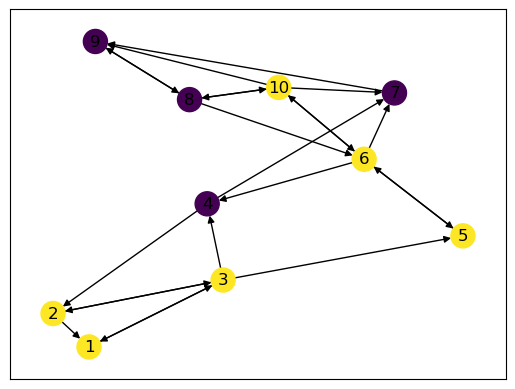

In [4]:
cmap = {
    -1: 0.,
    1: 1
}
opinions = nx.get_node_attributes(graph, name=OPINION_KEY)
nx.draw_networkx(graph, node_color=[opinions[node] for node in graph.nodes()])

In [5]:
graph, s, it = balance_opinions(graph, OPINION_KEY, SUGGESTABILITY_KEY)

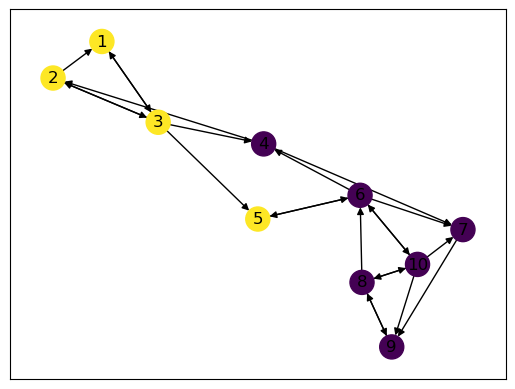

In [6]:
opinions = nx.get_node_attributes(graph, name=OPINION_KEY)
nx.draw_networkx(graph, node_color=[opinions[node] for node in graph.nodes()])

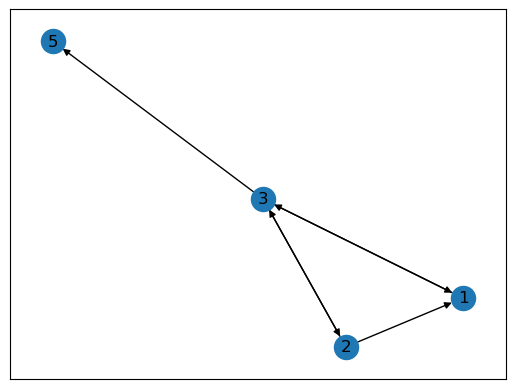

In [7]:
n, o = np.array([(node, opinions[node]) for node in graph.nodes()]).T
nx.draw_networkx(graph.subgraph(n[o == Opinion.plus_sigma]))

In [8]:
for s in seeds:
    break

In [10]:
type(s)

numpy.int64

# Расчет данных

In [2]:
# расчет данных
seed = 42
n_nodes = 1000
# avg_k = 10.02
avg_k = 3.93
p = avg_k / n_nodes
seed = 20160
f = 0.4
n_newtworks = 1000
np.random.seed(seed)
seeds = np.random.randint(1, 100005, size=int(n_newtworks * 1.1))

networks = []
ks = []
data = []
for s in tqdm(seeds):
    G = generate_er_graph(n_nodes, avg_k, f, BASE_SUGGESTABILITY, one_component=True, keep_n_nodes=False, seed=int(s))
    if len(G) < 10:
        continue

    networks.append(G)
    # ks.append(average_k(G))
    data.append(describe_graph(G))
    if len(networks) >= n_newtworks:
        break

graph_stat = pd.DataFrame(data)

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1023/1100 [00:53<00:04, 19.05it/s]


<AxesSubplot:xlabel='avg_k', ylabel='Count'>

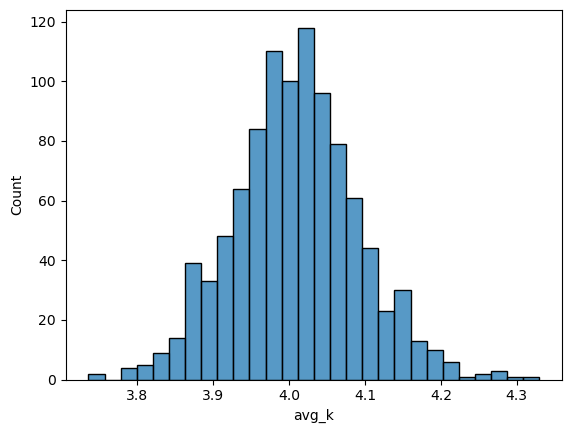

In [3]:
sns.histplot(graph_stat.avg_k)

In [4]:
graph_stat.describe(percentiles=[])

,nodes,n_components,avg_k,fraction,s1,s2
count,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,978.741000,1.0,4.009100,0.400187,0.251600,0.010383
std,5.130716,0.0,0.083011,0.015711,0.038211,0.008045
min,961.000000,1.0,3.735926,0.350823,0.073022,0.003043
50%,979.000000,1.0,4.008167,0.400000,0.255242,0.008180
max,992.000000,1.0,4.329626,0.455579,0.342975,0.108961


In [5]:
graph_stat.avg_k.mean()

4.009100192439549

In [48]:
from collections import defaultdict
from tqdm import tqdm

data = []
for sug in tqdm([4, 6, 8, 10]):
    for f in np.linspace(0, 0.5, 10):
        for G in networks:
            opinions = generate_opinions(G, f)
            nx.set_node_attributes(G, opinions, name=OPINION_KEY)
            nx.set_node_attributes(G, sug, name=SUGGESTABILITY_KEY)
            G, stable, _ = balance_opinions(G)
            d = describe_graph(G)
            d['f'] = f
            d['sug'] = sug
            data.append(d)
data = pd.DataFrame(data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [31:22<00:00, 470.59s/it]


In [56]:
data.to_csv('experiment_data_k10.csv')

In [26]:
data.avg_k.mean()

4.009100192439549

In [2]:
try:
    data
except NameError:
    data = pd.read_csv('experiment_data.csv')

In [34]:
def process_data(data: pd.DataFrame):
    gr_data = data[['f', 'sug', 'fraction', 's1', 's2']].groupby(['sug', 'f'])
    description = gr_data.describe()

    result = pd.DataFrame(index=description.index)
    for col in ['fraction', 's1', 's2']:
        result[f'{col}_mean'] = gr_data[col].mean()
        result[f'{col}_std'] = gr_data[col].std()
    return result

In [35]:
result = process_data(data)

In [30]:
result.tail()

fraction_mean  fraction_std   s1_mean    s1_std   s2_mean  \
sug f                                                                     
8.0 0.555556       0.554986      0.015229  0.476581  0.023815  0.004404   
    0.666667       0.666164      0.015092  0.616994  0.020746  0.003218   
    0.777778       0.777743      0.012973  0.750491  0.016200  0.002477   
    0.888889       0.889566      0.009913  0.878226  0.011663  0.001764   
    1.000000       1.000000      0.000000  1.000000  0.000000  0.000000   

                s2_std  
sug f                   
8.0 0.555556  0.001635  
    0.666667  0.001214  
    0.777778  0.000887  
    0.888889  0.000741  
    1.000000  0.000000

### Графики

#### Для одного suggestability

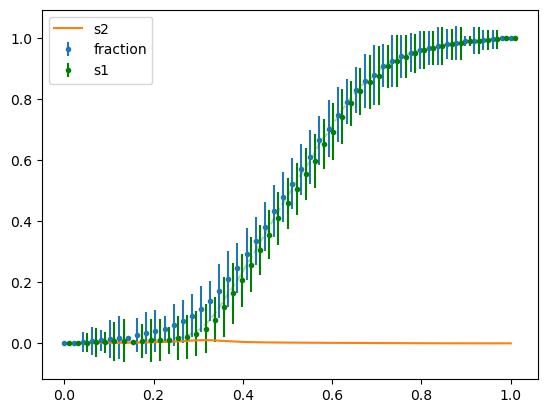

In [7]:
plt.figure()
plt.errorbar(result.index, result.fraction_mean, fmt='.', yerr=result.fraction_std, label='fraction')
plt.errorbar(result.index + np.diff(result.index).max()/2, result.s1_mean, fmt='.g', yerr=result.s1_std, label='s1')
plt.plot(result.index, result.s1_mean, '--g', alpha=.3)
plt.plot(result.index, result.s2_mean, label='s2')
plt.legend()

In [8]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

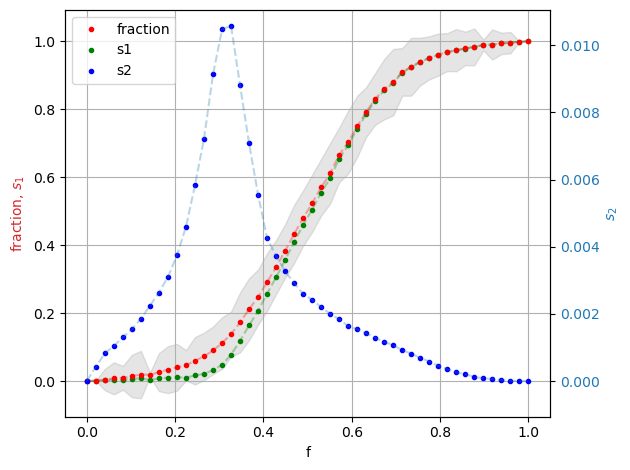

In [20]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('f')
ax1.set_ylabel('fraction, $s_1$', color=color)
plt.grid(True)

# ax1.errorbar(result.index, result.fraction_mean, fmt='r.', yerr=result.fraction_std, alpha=0.3, label='fraction')
# ax1.errorbar(result.index, result.s1_mean, fmt='.g', yerr=result.s1_std, label='s1')
ax1.plot(result.index, result.fraction_mean, '--r', alpha=0.3)
ax1.fill_between(result.index, result.fraction_mean - result.fraction_std, result.fraction_mean + result.fraction_std,
                 color='gray', alpha=0.2)

lns2 = ax1.plot(result.index, result.s1_mean, '.g', label='s1')
ax1.plot(result.index, result.s1_mean, '--g', alpha=0.3)

lns1 = ax1.plot(result.index, result.fraction_mean, '.r', label='fraction')
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('$s_2$', color=color)  # we already handled the x-label with ax1
lns3 = ax2.plot(result.index, result.s2_mean, '.b', label='s2')
ax2.plot(result.index, result.s2_mean, '--', alpha=0.3)
# ax2.errorbar(result.index, result.s2_mean, fmt='.', color=color, yerr=result.s2_std, label='s2')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ybound(upper=result.s2_mean.max() + 0.001)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
align_yaxis(ax1, 0, ax2, 0)
plt.savefig('fraction_s1_s2.png')
plt.show()

In [ ]:
graph, stable, n_iters = balance_opinions(G, OPINION_KEY, SUGGESTABILITY_KEY)

In [ ]:
stable, n_iters

(True, 3)

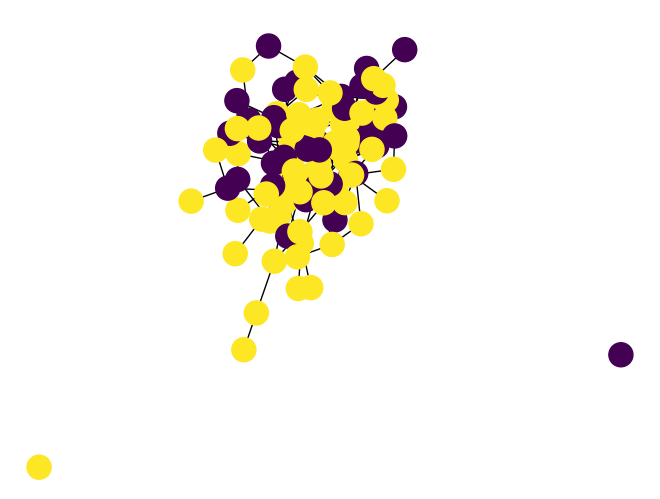

In [ ]:
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout
nx.draw(graph, pos=pos, node_color=[opinions[node] for node in G.nodes()])
plt.show()

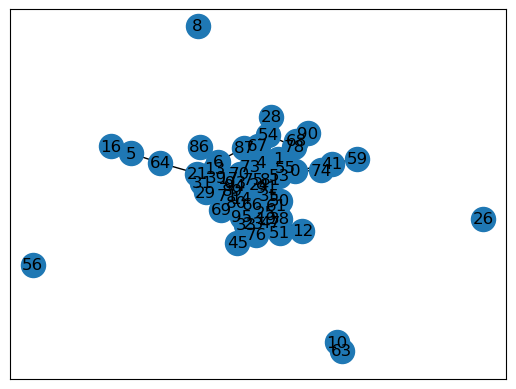

In [7]:
G = networks[0]
opinions = nx.get_node_attributes(G, name=OPINION_KEY)
n, o = np.array([(node, opinions[node]) for node in G.nodes()]).T
nx.draw_networkx(G.subgraph(n[o == Opinion.plus_sigma]))

In [ ]:
[len(g) for g in nx.connected_components(graph.subgraph(n[o == Opinion.plus_sigma]))], [len(g) for g in nx.connected_components(graph.subgraph(n[o == Opinion.minus_sigma]))]

([52, 1, 1, 4, 1, 1, 1, 1, 1],
 [10, 9, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
list(zip(*opinions.items()))

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99),
 (1,
  1,
  -1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,


#### Графики с разной убеждаемостью

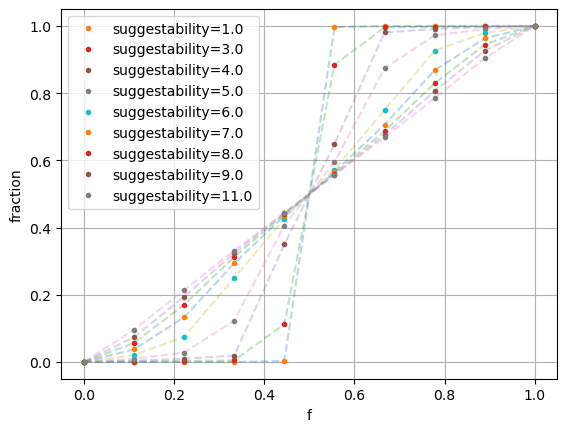

In [22]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('f')
ax1.set_ylabel('fraction')
plt.grid(True)

for suggestability in result.index.get_level_values(0).unique():
    r1 = result.loc[suggestability]
    ax1.plot(r1.index, r1.fraction_mean, '--', alpha=0.3)
    ax1.plot(r1.index, r1.fraction_mean, '.', label=f'{suggestability=}')

plt.legend()
plt.savefig('diff_suggest.png')

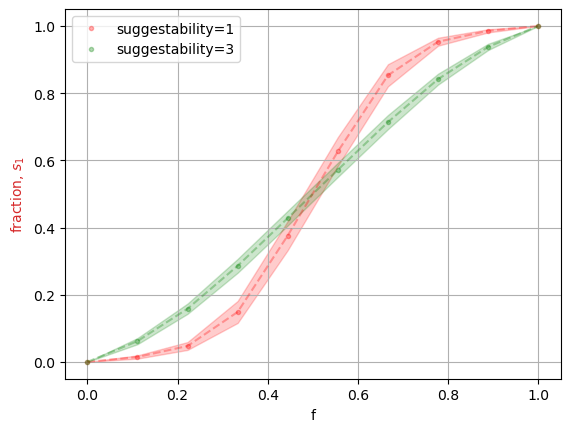

In [65]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('f')
ax1.set_ylabel('fraction, $s_1$', color=color)
plt.grid(True)

# ax1.errorbar(result.index, result.fraction_mean, fmt='r.', yerr=result.fraction_std, alpha=0.3, label='fraction')
# ax1.errorbar(result.index, result.s1_mean, fmt='.g', yerr=result.s1_std, label='s1')
ax1.plot(r1.index, r1.fraction_mean, '--r', alpha=0.3)
ax1.fill_between(r1.index, r1.fraction_mean - r1.fraction_std, r1.fraction_mean + r1.fraction_std,
                 color='red', alpha=0.2)

ax1.plot(r2.index, r2.fraction_mean, '--g', alpha=0.3)
ax1.fill_between(r2.index, r2.fraction_mean - r2.fraction_std, r2.fraction_mean + r2.fraction_std,
                 color='green', alpha=0.2)

ax1.plot(r1.index, r1.fraction_mean, '.r', alpha=0.3, label='suggestability=1')
ax1.plot(r2.index, r2.fraction_mean, '.g', alpha=0.3, label='suggestability=3')
plt.legend()
# lns1 = ax1.plot(result.index, result.fraction_mean, '.r', label='fraction')
# ax1.tick_params(axis='y', labelcolor=color)
plt.show()

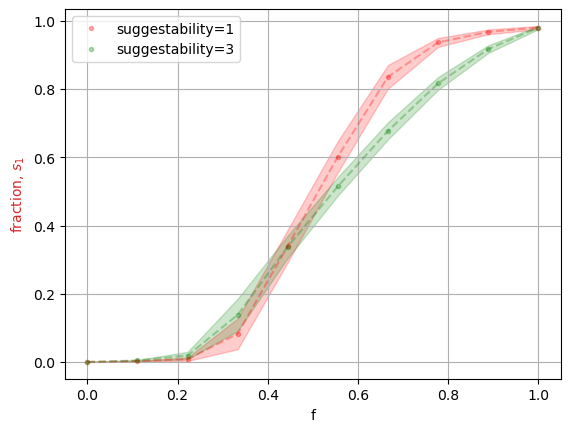

In [56]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('f')
ax1.set_ylabel('fraction, $s_1$', color=color)
plt.grid(True)

# ax1.errorbar(result.index, result.fraction_mean, fmt='r.', yerr=result.fraction_std, alpha=0.3, label='fraction')
# ax1.errorbar(result.index, result.s1_mean, fmt='.g', yerr=result.s1_std, label='s1')
ax1.plot(r1.f, r1.s1_mean, '--r', alpha=0.3)
ax1.fill_between(r1.f, r1.s1_mean - r1.s1_std, r1.s1_mean + r1.s1_std,
                 color='red', alpha=0.2)

ax1.plot(r2.f, r2.s1_mean, '--g', alpha=0.3)
ax1.fill_between(r2.f, r2.s1_mean - r2.s1_std, r2.s1_mean + r2.s1_std,
                 color='green', alpha=0.2)

ax1.plot(r1.f, r1.s1_mean, '.r', alpha=0.3, label='suggestability=1')
ax1.plot(r2.f, r2.s1_mean, '.g', alpha=0.3, label='suggestability=3')
plt.legend()
# lns1 = ax1.plot(result.index, result.fraction_mean, '.r', label='fraction')
# ax1.tick_params(axis='y', labelcolor=color)
plt.show()

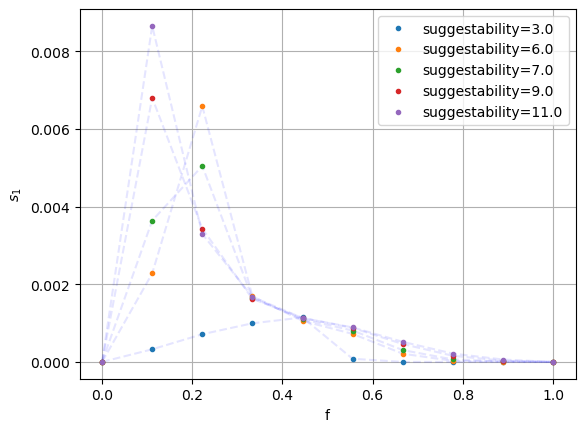

In [29]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('f')
ax1.set_ylabel('$s_1$')
plt.grid(True)

for suggestability in [3.0, 6.0, 7.0, 9.0, 11.0]: # result.index.get_level_values(0).unique():
    r1 = result.loc[suggestability]
    ax1.plot(r1.index, r1.s2_mean, 'b--', alpha=0.1)
    ax1.plot(r1.index, r1.s2_mean, '.', label=f'{suggestability=}')
ax1.legend()
plt.savefig('diff_suggest_s2.png')

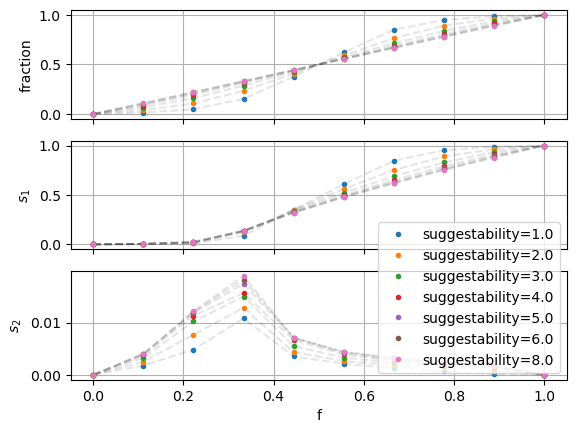

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

# colors = 'rgbm'
labels = ['fraction', '$s_1$', '$s_2$']

for suggestability in result.index.get_level_values(0).unique():
    r1 = result.loc[suggestability]
    ax1.plot(r1.index, r1.fraction_mean, 'k--', alpha=0.1)
    ax1.plot(r1.index, r1.fraction_mean, '.', label=f'{suggestability=}')
    
    ax2.plot(r1.index, r1.s1_mean, 'k--', alpha=0.1)
    ax2.plot(r1.index, r1.s1_mean, '.', label=f'{suggestability=}')
    
    ax3.plot(r1.index, r1.s2_mean, 'k--', alpha=0.1)
    ax3.plot(r1.index, r1.s2_mean, '.', label=f'{suggestability=}')

ax3.set_xlabel('f')
for l, ax in zip(labels, (ax1, ax2, ax3)):
    ax.set_ylabel(l)
    ax.grid(True)
    # ax.axis('equal')

ax3.legend()
plt.savefig('diff_suggest_k4.png')

In [57]:
k4 = process_data(pd.read_csv('experiment_data_k4.csv'))
k10 = process_data(pd.read_csv('experiment_data_k10.csv'))

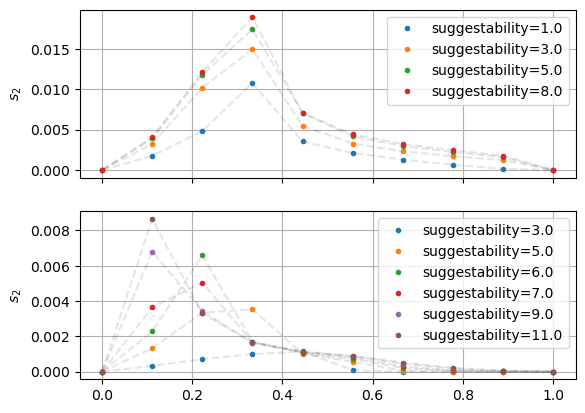

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# colors = 'rgbm'
labels = ['$s_2$', '$s_2$']

for suggestability in result.index.get_level_values(0).unique():
    if suggestability in [2., 4., 6.]: continue
    r1 = k4.loc[suggestability]
    ax1.plot(r1.index, r1.s2_mean, 'k--', alpha=0.1)
    ax1.plot(r1.index, r1.s2_mean, '.', label=f'{suggestability=}')

for suggestability in k10.index.get_level_values(0).unique():
    if suggestability in [1., 4., 8., 10.]: continue
    r1 = k10.loc[suggestability]
    ax2.plot(r1.index, r1.s2_mean, 'k--', alpha=0.1)
    ax2.plot(r1.index, r1.s2_mean, '.', label=f'{suggestability=}')

ax3.set_xlabel('f')
for l, ax in zip(labels, (ax1, ax2)):
    ax.set_ylabel(l)
    ax.grid(True)
    # ax.axis('equal')

ax1.legend()
ax2.legend()
plt.savefig('diff_suggest_s2_k410.png')

# Посчитанные данные для $\left<k\right>=4,\,8,\,16$

In [2]:
def load_data(path: str, processed: bool = True):
    file = 'processed.csv' if processed else 'raw.csv'
    index_col = 0 if processed else None
    return pd.read_csv(os.path.join(path, file), index_col=0)

In [8]:
k4_data = load_data('data/erd_ren_k4_n1000')
k8_data = load_data('data/erd_ren_k8_n1000')
k12_data = load_data('data/erd_ren_k12_n1000')
k16_data = load_data('data/erd_ren_k16_n1000')

ab_m2_data = load_data('data/bar_alb_k4_n2000/')
ab_m4_data = load_data('data/bar_alb_k8_n2000/')
ab_m6_data = load_data('data/bar_alb_k12_n2000/')
ab_m8_data = load_data('data/bar_alb_k16_n2000/')

rr_d4_data = load_data('data/random_regular_k4_n2000/')
rr_d8_data = load_data('data/random_regular_k8_n2000/')
rr_d12_data = load_data('data/random_regular_k12_n2000/')
rr_d16_data = load_data('data/random_regular_k16_n2000/')

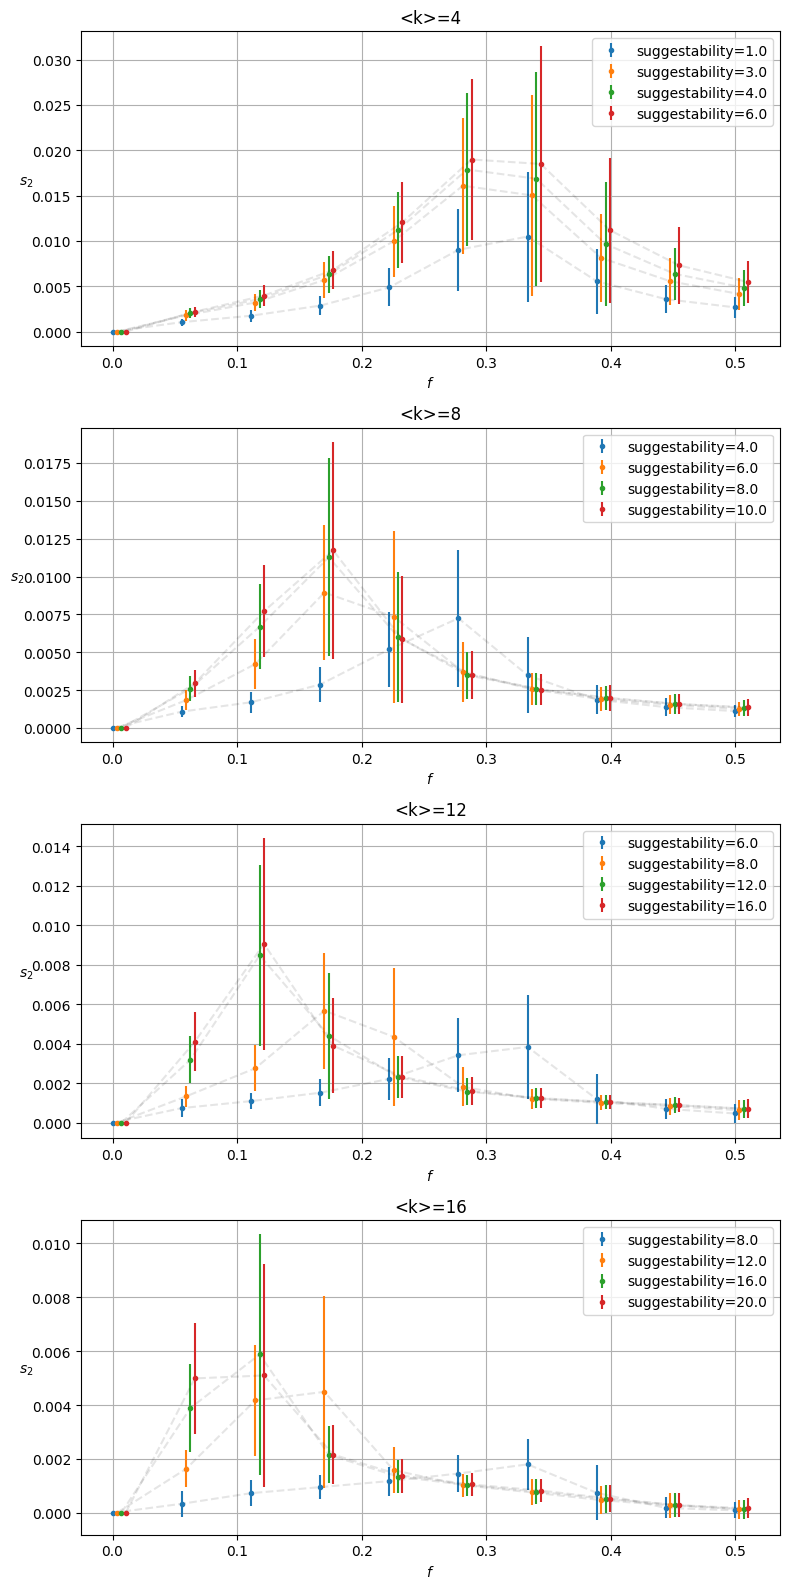

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

for ax, data, k in zip(axs, [k4_data, k8_data, k12_data, k16_data], [4, 8, 12, 16]):
    ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
        r1 = data.loc[suggestability]
        ax.plot(r1.f + i * 35e-4, r1.s2_mean, 'k--', alpha=0.1)
        # ax.plot(r1.f, r1.s2_mean, '.', label=f'{suggestability=}')
        ax.errorbar(r1.f + i * 35e-4, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'{suggestability=}')
        # ax.fill_between(r1.f, r1.s2_mean - r1.s2_std, r1.s2_mean + r1.s2_std,
        #          color='grey', alpha=0.2)
    ax.set_xlabel('$f$')
    ax.set_ylabel('$s_2$', rotation=0)
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.savefig('figures/diff_suggest_s2.png')

In [ ]:
1, 3, 6, 8, 10, 13, 16, 22, 32

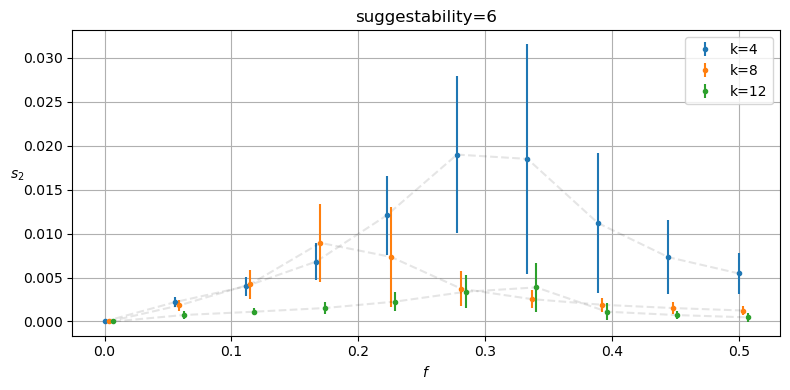

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))

suggestability = 6

ax.set_title(f'{suggestability=}')
for i, (data, k) in enumerate(zip([k4_data, k8_data, k12_data], [4, 8, 12, 16])):
    r1 = data.loc[suggestability]
    ax.plot(r1.f + i * 35e-4, r1.s2_mean, 'k--', alpha=0.1)
    # ax.plot(r1.f, r1.s2_mean, '.', label=f'{suggestability=}')
    ax.errorbar(r1.f + i * 35e-4, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'{k=}')
        # ax.fill_between(r1.f, r1.s2_mean - r1.s2_std, r1.s2_mean + r1.s2_std,
        #          color='grey', alpha=0.2)
    ax.set_xlabel('$f$')
    ax.set_ylabel('$s_2$', rotation=0)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig('figures/diff_suggest6_s2.png')

In [33]:
!PYTHONPATH=./ python scripts/evaluate_networks.py configs/config_k8.json y

Overwriting existing directory
Reading 2000 networks from directory networks/k=8
100%|███████████████████████████████████████| 2000/2000 [02:42<00:00, 12.33it/s]
Evaluating suggestability=4
100%|███████████████████████████████████████████| 10/10 [15:20<00:00, 92.09s/it]
Evaluating suggestability=6
100%|███████████████████████████████████████████| 10/10 [13:48<00:00, 82.86s/it]
Evaluating suggestability=8
100%|███████████████████████████████████████████| 10/10 [11:37<00:00, 69.75s/it]
Evaluating suggestability=10
100%|███████████████████████████████████████████| 10/10 [11:32<00:00, 69.27s/it]
Saving data into data/erd_ren_k8_n1000


In [34]:
!PYTHONPATH=./ python scripts/evaluate_networks.py configs/config_k16.json y

Overwriting existing directory
Reading 2000 networks from directory networks/k=16
100%|███████████████████████████████████████| 2000/2000 [07:06<00:00,  4.69it/s]
Evaluating suggestability=8
100%|██████████████████████████████████████████| 10/10 [24:14<00:00, 145.40s/it]
Evaluating suggestability=12
100%|██████████████████████████████████████████| 10/10 [22:12<00:00, 133.29s/it]
Evaluating suggestability=16
100%|██████████████████████████████████████████| 10/10 [20:09<00:00, 120.96s/it]
Evaluating suggestability=20
100%|██████████████████████████████████████████| 10/10 [18:59<00:00, 113.98s/it]
Saving data into data/erd_ren_k16_n1000


In [5]:
ab_m2_data = load_data('data/bar_alb_k4_n2000/')
ab_m4_data = load_data('data/bar_alb_k8_n2000/')
ab_m6_data = load_data('data/bar_alb_k12_n2000/')

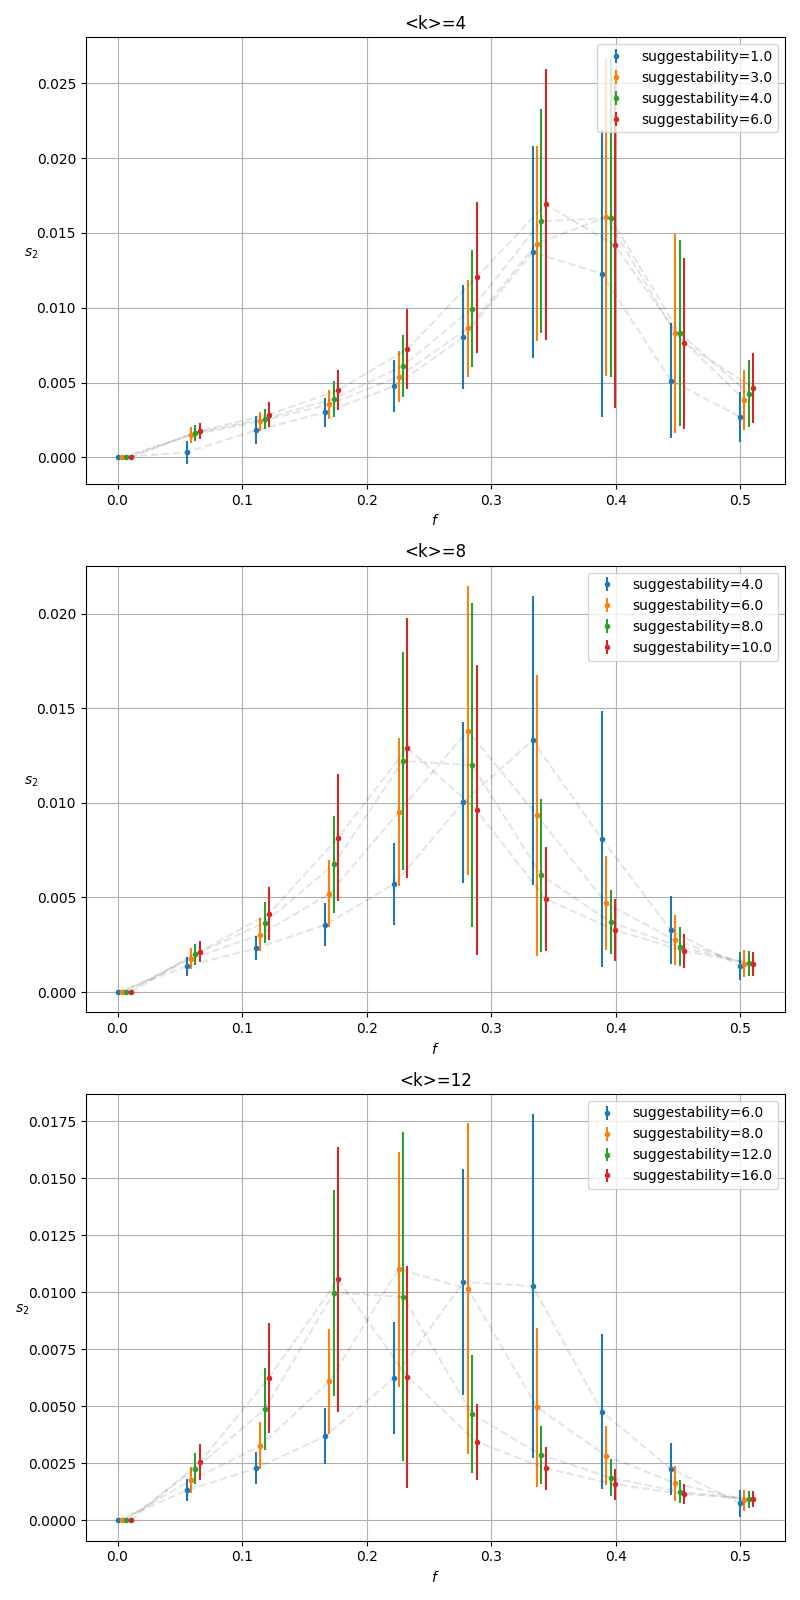

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for ax, data, k in zip(axs, [ab_m2_data, ab_m4_data, ab_m6_data], [4, 8, 12]):
    ax.set_title(f'<k>={k}')
    for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
        r1 = data.loc[suggestability]
        ax.plot(r1.f + i * 35e-4, r1.s2_mean, 'k--', alpha=0.1)
        # ax.plot(r1.f, r1.s2_mean, '.', label=f'{suggestability=}')
        ax.errorbar(r1.f + i * 35e-4, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'{suggestability=}')
        # ax.fill_between(r1.f, r1.s2_mean - r1.s2_std, r1.s2_mean + r1.s2_std,
        #          color='grey', alpha=0.2)
    ax.set_xlabel('$f$')
    ax.set_ylabel('$s_2$', rotation=0)
    ax.legend()
    ax.grid(True)
plt.tight_layout()

In [9]:
ab_m4_data.describe()

,f,fraction_mean,fraction_std,s1_mean,s1_std,s2_mean,s2_std
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.250000,0.140433,0.026132,0.099003,0.029047,0.003543,0.001904
std,0.161604,0.170138,0.063806,0.165654,0.065074,0.004165,0.002487
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.111111,0.000009,0.000093,0.000009,0.000093,0.000000,0.000000
50%,0.250000,0.062758,0.010823,0.007097,0.003573,0.002037,0.000907
75%,0.388889,0.238526,0.021194,0.118577,0.038944,0.005373,0.002411
max,0.500000,0.509454,0.394776,0.509452,0.394776,0.014072,0.008021


In [10]:
ab_m4_data.index

Index([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0,
       3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,
       4.0, 4.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0],
      dtype='float64', name='sug')

In [9]:
all_data = [
    [k4_data, k8_data, k12_data, k16_data],
    [ab_m2_data, ab_m4_data, ab_m6_data, ab_m8_data],
    [rr_d4_data, rr_d8_data, rr_d12_data, rr_d16_data]
]

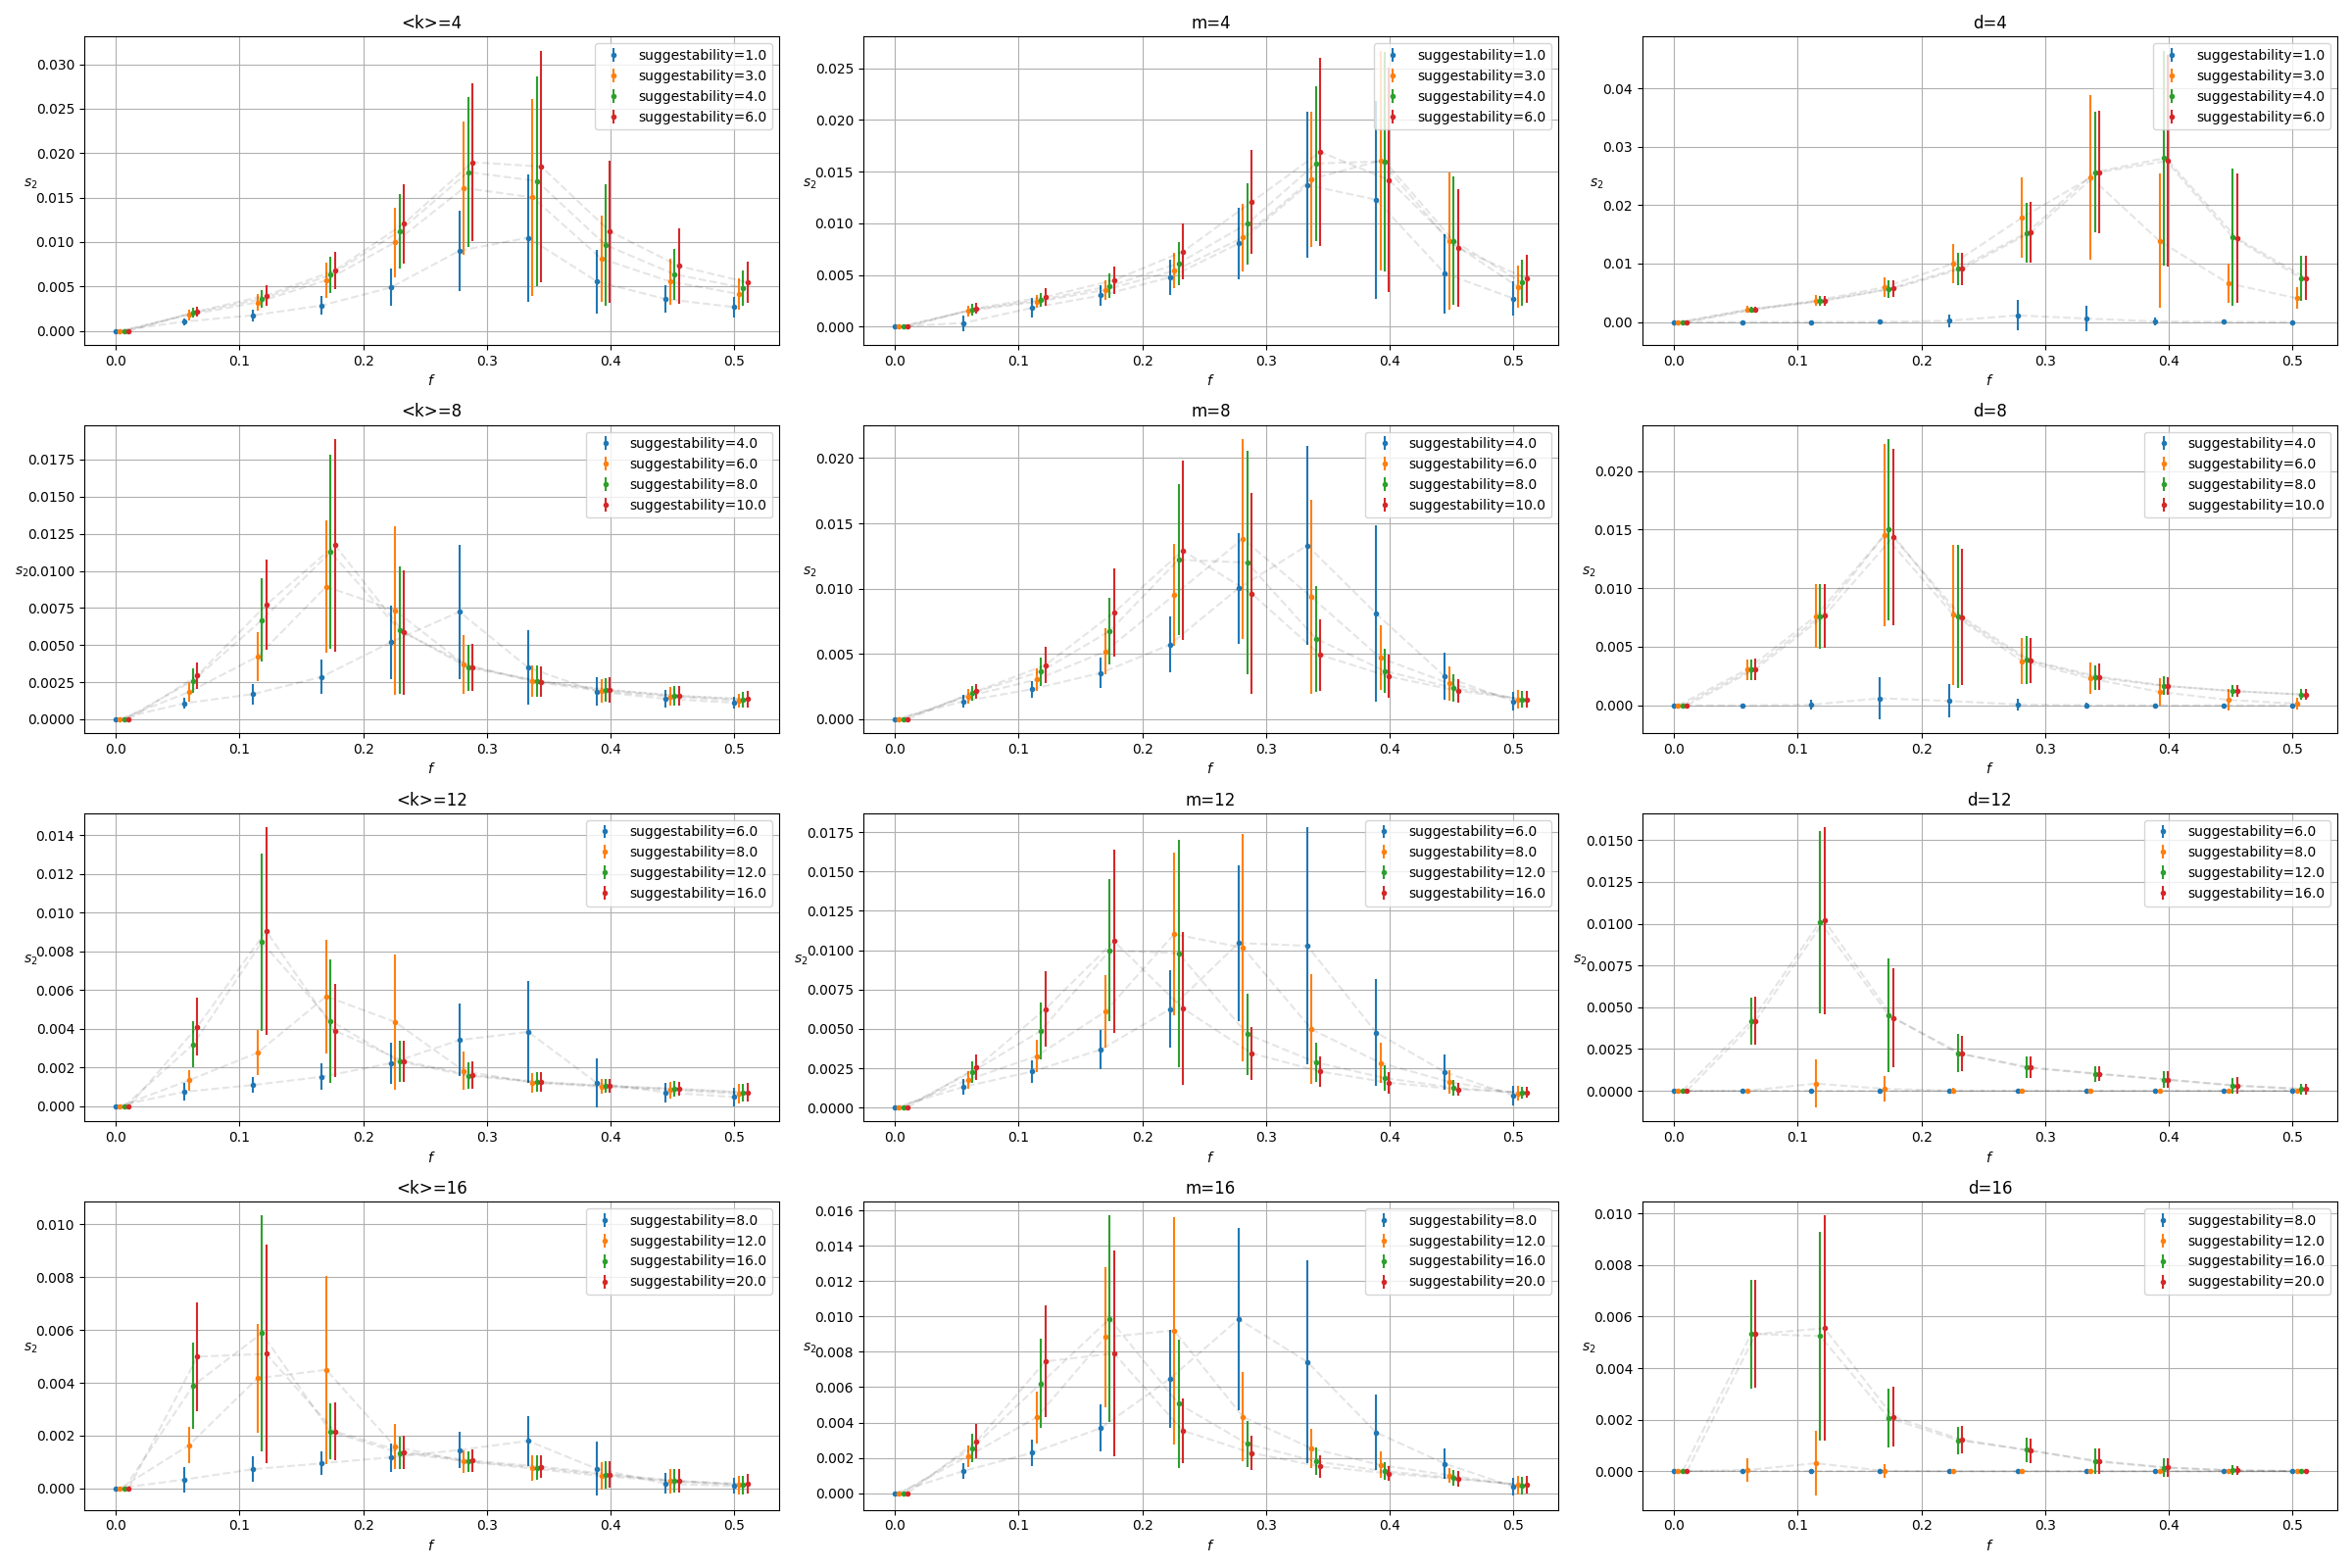

In [13]:
fig, all_axs = plt.subplots(4, 3, figsize=(24, 16))

prms = [
    [4, 8, 12, 16],
    [2, 4, 6, 8],
    [4, 8, 12, 16]
]

for axs, full_data, symb in zip(all_axs.T, all_data, ['<k>', 'm', 'd']):
    for ax, data, k in zip(axs, full_data, [4, 8, 12, 16]):
        ax.set_title(f'{symb}={k}')
        for i, suggestability in enumerate(data.index.get_level_values(0).unique()):
            r1 = data.loc[suggestability]
            ax.plot(r1.f + i * 35e-4, r1.s2_mean, 'k--', alpha=0.1)
            # ax.plot(r1.f, r1.s2_mean, '.', label=f'{suggestability=}')
            ax.errorbar(r1.f + i * 35e-4, r1.s2_mean, yerr=r1.s2_std, fmt='.', label=f'{suggestability=}')
            # ax.fill_between(r1.f, r1.s2_mean - r1.s2_std, r1.s2_mean + r1.s2_std,
            #          color='grey', alpha=0.2)
        ax.set_xlabel('$f$')
        ax.set_ylabel('$s_2$', rotation=0)
        ax.legend()
        ax.grid(True)
plt.tight_layout()
plt.savefig('figures/diff_suggest_s2.png')

In [7]:
axs.T

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)